# Flight Status Predictor

**What problem are we trying to solve?**

The goal of this project is to **develop and deploy an ML model** in which an end user can specify a set of features describing a commercial flight of interest and receive a categorical (yes or no) output indicating if the arrival time of that flight will be delayed more than fifteen minutes or not. 

**Answer these questions about the data:**
- What variables contribute to a flight being delayed or not upon arrival?
- Which model best represents the data? 

In [2]:
# Import libraries 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
%matplotlib inline

In [4]:
# Store CSV file in variable 
flights = r'..\data\DF_from_Feature_Sel_for_Model_Sel.csv'
# Read CSV file in pandas dataframe 
df = pd.read_csv(flights)

In [6]:
# Print dataframe to confirm successful loading
df

,Carrier_Name,Week_Day,Flight_Date,Flight_Number,Origin_City_State,Destination_City_State,Dep_Time_Block_Group,Scheduled_Departure_Time,Scheduled_Arrival_Time,Scheduled_Gate_to_Gate_Time,Distance_Miles,Distance_Group,delayed
0,United Air Lines Inc.,Tuesday,2023-09-05,773,"Denver, CO","Nashville, TN",Afternoon,1743,2119,156,1014,5,0
1,Delta Air Lines Inc.,Friday,2024-03-29,2641,"Salt Lake City, UT","Seattle, WA",Afternoon,1710,1823,133,689,3,0
2,American Airlines Inc.,Sunday,2023-06-04,2677,"Orlando, FL","Dallas/Fort Worth, TX",Early Morning,550,745,175,985,4,0
3,Delta Air Lines Inc.,Friday,2023-08-04,1451,"Jacksonville, FL","Boston, MA",Early Afternoon,1215,1459,164,1010,5,1
4,Southwest Airlines Co.,Tuesday,2023-04-18,185,"Dallas, TX","Indianapolis, IN",Evening,1955,2255,120,755,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2742897,SkyWest Airlines Inc.,Thursday,2023-10-26,4815,"Dallas/Fort Worth, TX","Killeen, TX",Morning,1044,1202,78,134,1,1
2742898,Southwest Airlines Co.,Thursday,2023-07-20,4277,"Las Vegas, NV","El Paso, TX",Afternoon,1620,1905,105,583,3,1
2742899,Endeavor Air Inc.,Saturday,2024-01-27,4915,"Des Moines, IA","New York, NY",Early Afternoon,1300,1644,164,1031,5,0
2742900,Southwest Airlines Co.,Thursday,2023-07-20,1817,"Phoenix, AZ","St. Louis, MO",Evening,2015,115,180,1262,6,1


In [8]:
df.columns

Index(['Carrier_Name', 'Week_Day', 'Flight_Date', 'Flight_Number',
       'Origin_City_State', 'Destination_City_State', 'Dep_Time_Block_Group',
       'Scheduled_Departure_Time', 'Scheduled_Arrival_Time',
       'Scheduled_Gate_to_Gate_Time', 'Distance_Miles', 'Distance_Group',
       'delayed'],
      dtype='object')

# Data Preprocessing (Data Cleaning and Preparation)

<span style="color:red">**NOTE**</span>: This step was mostly taken care of during EDA and Feature Selection, but wanted to still view the data and make any necessary adjustments

**Get Summary of dataset**

In [11]:
# Get summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742902 entries, 0 to 2742901
Data columns (total 13 columns):
 #   Column                       Dtype 
---  ------                       ----- 
 0   Carrier_Name                 object
 1   Week_Day                     object
 2   Flight_Date                  object
 3   Flight_Number                int64 
 4   Origin_City_State            object
 5   Destination_City_State       object
 6   Dep_Time_Block_Group         object
 7   Scheduled_Departure_Time     int64 
 8   Scheduled_Arrival_Time       int64 
 9   Scheduled_Gate_to_Gate_Time  int64 
 10  Distance_Miles               int64 
 11  Distance_Group               int64 
 12  delayed                      int64 
dtypes: int64(7), object(6)
memory usage: 272.0+ MB


Columns that need to be converted to Object dtype: 
- Flight_Number

Holding off on converting since some columns will not be needed for analysis

Let us move on to checking for **NULL** and **Duplicate** values 

In [14]:
# Check for missing values 
print(df.isnull().sum())

Carrier_Name                   0
Week_Day                       0
Flight_Date                    0
Flight_Number                  0
Origin_City_State              0
Destination_City_State         0
Dep_Time_Block_Group           0
Scheduled_Departure_Time       0
Scheduled_Arrival_Time         0
Scheduled_Gate_to_Gate_Time    0
Distance_Miles                 0
Distance_Group                 0
delayed                        0
dtype: int64


In [16]:
# Check for duplicate entries
df[df.duplicated()]

,Carrier_Name,Week_Day,Flight_Date,Flight_Number,Origin_City_State,Destination_City_State,Dep_Time_Block_Group,Scheduled_Departure_Time,Scheduled_Arrival_Time,Scheduled_Gate_to_Gate_Time,Distance_Miles,Distance_Group,delayed


As stated before during EDA and Feature Selection, there doesn't appear to be any duplicated rows

Remember, during EDA, we already renamed the target variable column **Arr_Delay_At_Least_15_Minutes** to **delayed**

In [22]:
df.columns

Index(['Carrier_Name', 'Week_Day', 'Flight_Date', 'Flight_Number',
       'Origin_City_State', 'Destination_City_State', 'Dep_Time_Block_Group',
       'Scheduled_Departure_Time', 'Scheduled_Arrival_Time',
       'Scheduled_Gate_to_Gate_Time', 'Distance_Miles', 'Distance_Group',
       'delayed'],
      dtype='object')

---

# Feature Selection

Based off the information gathered in Feature Selection using the Phik Coreelation Matrix, the following features will be used for model selection: 

> Categorical Variables:
> - Carrier_Name
> - Dep_Time_Block_Group
> - Flight_Date (Month) - Will need to convert this to actual month (Jan, Feb, Mar, etc.) to avoid ordinality with numbers
>
> Numeric Variables:
> - Scheduled_Arrival_Time
> - Scheduled_Departure_Time
> - Flight_Date (Year)
> - Flight_Date (Day)
> - delayed (target variable)

In [75]:
# Add highly correlated features into a new dataframe 
df_features = pd.DataFrame(data=df[['Carrier_Name', 'Flight_Date', 'Dep_Time_Block_Group', 'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'delayed']])
df_features

,Carrier_Name,Flight_Date,Dep_Time_Block_Group,Scheduled_Arrival_Time,Scheduled_Departure_Time,delayed
0,United Air Lines Inc.,2023-09-05,Afternoon,2119,1743,0
1,Delta Air Lines Inc.,2024-03-29,Afternoon,1823,1710,0
2,American Airlines Inc.,2023-06-04,Early Morning,745,550,0
3,Delta Air Lines Inc.,2023-08-04,Early Afternoon,1459,1215,1
4,Southwest Airlines Co.,2023-04-18,Evening,2255,1955,1
...,...,...,...,...,...,...
2742897,SkyWest Airlines Inc.,2023-10-26,Morning,1202,1044,1
2742898,Southwest Airlines Co.,2023-07-20,Afternoon,1905,1620,1
2742899,Endeavor Air Inc.,2024-01-27,Early Afternoon,1644,1300,0
2742900,Southwest Airlines Co.,2023-07-20,Evening,115,2015,1


In [77]:
# Convert 'Flight_Date' to datetime objects
df_features['Flight_Date'] = pd.to_datetime(df_features['Flight_Date'])

# Extract month and year
df_features['Month'] = df_features['Flight_Date'].dt.month
df_features['Year'] = df_features['Flight_Date'].dt.year
df_features['Day'] = df_features['Flight_Date'].dt.day

In [79]:
df_features

,Carrier_Name,Flight_Date,Dep_Time_Block_Group,Scheduled_Arrival_Time,Scheduled_Departure_Time,delayed,Month,Year,Day
0,United Air Lines Inc.,2023-09-05,Afternoon,2119,1743,0,9,2023,5
1,Delta Air Lines Inc.,2024-03-29,Afternoon,1823,1710,0,3,2024,29
2,American Airlines Inc.,2023-06-04,Early Morning,745,550,0,6,2023,4
3,Delta Air Lines Inc.,2023-08-04,Early Afternoon,1459,1215,1,8,2023,4
4,Southwest Airlines Co.,2023-04-18,Evening,2255,1955,1,4,2023,18
...,...,...,...,...,...,...,...,...,...
2742897,SkyWest Airlines Inc.,2023-10-26,Morning,1202,1044,1,10,2023,26
2742898,Southwest Airlines Co.,2023-07-20,Afternoon,1905,1620,1,7,2023,20
2742899,Endeavor Air Inc.,2024-01-27,Early Afternoon,1644,1300,0,1,2024,27
2742900,Southwest Airlines Co.,2023-07-20,Evening,115,2015,1,7,2023,20


In [81]:
# Convert Month to actual month (Jan, Feb, Mar, etc.)
df_features['Month'] = pd.to_datetime(df_features['Month'], format="%m").dt.strftime("%b")

In [83]:
df_features

,Carrier_Name,Flight_Date,Dep_Time_Block_Group,Scheduled_Arrival_Time,Scheduled_Departure_Time,delayed,Month,Year,Day
0,United Air Lines Inc.,2023-09-05,Afternoon,2119,1743,0,Sep,2023,5
1,Delta Air Lines Inc.,2024-03-29,Afternoon,1823,1710,0,Mar,2024,29
2,American Airlines Inc.,2023-06-04,Early Morning,745,550,0,Jun,2023,4
3,Delta Air Lines Inc.,2023-08-04,Early Afternoon,1459,1215,1,Aug,2023,4
4,Southwest Airlines Co.,2023-04-18,Evening,2255,1955,1,Apr,2023,18
...,...,...,...,...,...,...,...,...,...
2742897,SkyWest Airlines Inc.,2023-10-26,Morning,1202,1044,1,Oct,2023,26
2742898,Southwest Airlines Co.,2023-07-20,Afternoon,1905,1620,1,Jul,2023,20
2742899,Endeavor Air Inc.,2024-01-27,Early Afternoon,1644,1300,0,Jan,2024,27
2742900,Southwest Airlines Co.,2023-07-20,Evening,115,2015,1,Jul,2023,20


In [85]:
# Drop unnecessary columns from new dataframe 
df_features.drop(['Flight_Date'], axis=1, inplace=True)

In [87]:
df_features

,Carrier_Name,Dep_Time_Block_Group,Scheduled_Arrival_Time,Scheduled_Departure_Time,delayed,Month,Year,Day
0,United Air Lines Inc.,Afternoon,2119,1743,0,Sep,2023,5
1,Delta Air Lines Inc.,Afternoon,1823,1710,0,Mar,2024,29
2,American Airlines Inc.,Early Morning,745,550,0,Jun,2023,4
3,Delta Air Lines Inc.,Early Afternoon,1459,1215,1,Aug,2023,4
4,Southwest Airlines Co.,Evening,2255,1955,1,Apr,2023,18
...,...,...,...,...,...,...,...,...
2742897,SkyWest Airlines Inc.,Morning,1202,1044,1,Oct,2023,26
2742898,Southwest Airlines Co.,Afternoon,1905,1620,1,Jul,2023,20
2742899,Endeavor Air Inc.,Early Afternoon,1644,1300,0,Jan,2024,27
2742900,Southwest Airlines Co.,Evening,115,2015,1,Jul,2023,20


In [89]:
# Check for missing values 
print(df_features.isnull().sum())

Carrier_Name                0
Dep_Time_Block_Group        0
Scheduled_Arrival_Time      0
Scheduled_Departure_Time    0
delayed                     0
Month                       0
Year                        0
Day                         0
dtype: int64


In [91]:
# Grouping numerical columns and
# Moving the target variable to be the right-most column

# Columns to move
cols_to_move = [
                'Carrier_Name',
                'Dep_Time_Block_Group',
                'Month',
                'Year',
                'Day',
                'Scheduled_Arrival_Time', 
                'Scheduled_Departure_Time'
                ]

last_col = 'delayed'

# Extracting the columns to move
columns_to_move = df_features[cols_to_move]

# Dropping these columns from the DataFrame
df_features.drop(columns=cols_to_move, inplace=True)

# Extracting the last column
last_column = df_features.pop(last_col)

# Reinserting the numerical columns
df_features = pd.concat([df_features, columns_to_move], axis=1)

# Reinserting the last column
df_features[last_col] = last_column

df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742902 entries, 0 to 2742901
Data columns (total 8 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   Carrier_Name              object
 1   Dep_Time_Block_Group      object
 2   Month                     object
 3   Year                      int32 
 4   Day                       int32 
 5   Scheduled_Arrival_Time    int64 
 6   Scheduled_Departure_Time  int64 
 7   delayed                   int64 
dtypes: int32(2), int64(3), object(3)
memory usage: 146.5+ MB


In [93]:
# Define categorical and numerical features
categorical_features = ['Carrier_Name', 'Dep_Time_Block_Group', 'Month']
numerical_features = ['Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Year', 'Day']

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Redefine X (features) and y (target) variables
X = df_features[['Carrier_Name', 'Year', 'Month', 'Day', 'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 
                'Dep_Time_Block_Group']]
y = df_features["delayed"]

# Apply the preprocessing pipeline to X
x_preprocessed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_preprocessed, y, test_size=0.2, random_state=42)

print(f"x_train shape: {X_train.shape}")
print(f"x_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (2194321, 37)
x_test shape: (548581, 37)
y_train shape: (2194321,)
y_test shape: (548581,)


---

# Model Selection

### Logistic Regression

In [139]:
# Logistic regression model
logreg = LogisticRegression(random_state=42)

# Train and evaluate the model
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Print the results
print("Results of confusion matrix for logistic regression model:")
print(cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Results of confusion matrix for logistic regression model:
[[164918 109501]
 [ 99262 174900]]

True Positives(TP) =  164918

True Negatives(TN) =  174900

False Positives(FP) =  109501

False Negatives(FN) =  99262


In [141]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61    274419
           1       0.61      0.64      0.63    274162

    accuracy                           0.62    548581
   macro avg       0.62      0.62      0.62    548581
weighted avg       0.62      0.62      0.62    548581



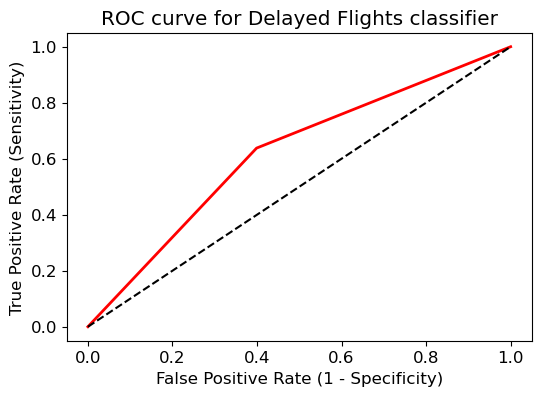

In [177]:
# Calculate ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)

# Initialize figure and axes
plt.figure(figsize=(6,4))
plt.plot(fpr_lr, tpr_lr, linewidth=2, color='red')
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Delayed Flights classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

In [101]:
# Calculate Accuracy Rate for Logistic Regression Model
score =accuracy_score(y_test,y_pred)
print('Model accuracy score: {0:0.4f}'.format(score * 100), '%')

Model accuracy score: 61.9449 %


In [111]:
# Calculate Error Rate for Logistic Regression Model
ER = ((273665 + 380) / (1081233 + 380 + 273665 + 318)) * 100
print('Model Error Rate: {0:0.4f}'.format(ER), '%')

Model Error Rate: 20.2158 %


In [179]:
# Print the scores on training and test set
print('Training set score: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(logreg.score(X_test, y_test)))

Training set score: 0.6204
Test set score: 0.6194
